In [1]:
import pandas as pd
import numpy as np
import statistics
from statistics import mode
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm
import warnings
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

In [2]:
def bayesian_LR(player):
    RANDOM_SEED = 8296
    np.random.seed(RANDOM_SEED)
    
    player_str = str(player)
    
    player_df = df[df['Player'] == player]
    player_df = player_df.sort_values(by=['year', 'week'])
    
    player_train = player_df[(player_df['year'] == 2019)  | (df['year'] == 2020)]
    player_test = player_df[player_df['year'] == 2021]
    
    player_to_scale_train = player_train[['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds']]
    player_to_scale_test = player_test[['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds']]

    scaler = MinMaxScaler()
    scaled_train_player = scaler.fit_transform(player_to_scale_train)
    scaled_train_player_df = pd.DataFrame(scaled_train_player, columns =['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds'])

    scaled_test_player = scaler.fit_transform(player_to_scale_test)
    scaled_test_player_df = pd.DataFrame(scaled_test_player, columns =['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds'])
    
    ##Defining Model
    with pm.Model() as player_model:
        #Data
        rushing_att = pm.MutableData("RushingAtt", scaled_train_player_df['RushingAtt'].values)
        rushing_yd = pm.MutableData("RushingYds", scaled_train_player_df['RushingYds'].values)
        rushing_td = pm.MutableData("RushingTD", scaled_train_player_df['RushingTD'].values)
        rec = pm.MutableData("Rec", scaled_train_player_df['Rec'].values)
        receiving_yds = pm.MutableData("ReceivingYds", scaled_train_player_df['ReceivingYds'].values)

        #prior
        intercept = pm.HalfCauchy('intercept', .001)

        #slope
        slope = pm.Gamma("slope", alpha = 50, beta =1)

        #linear regression
        mu = (
            intercept + (slope * rushing_att) + (slope * rushing_yd) + (slope * rushing_td) 
            + (slope * receiving_yds) + (slope * rec))

        #noise
        eps = pm.HalfNormal("eps", 1.0)

        pm.Normal(
        "PPRFantasyPoints",
        mu=mu,
        sigma=eps,
        observed= player_train['PPRFantasyPoints'].values
        )
        
    ##Sampling
    with player_model:
        idata = pm.sample(random_seed=RANDOM_SEED)
        idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
        idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))
        
    ##Creating Predictions
    with player_model:
        pm.set_data(
            {
                "RushingAtt": scaled_test_player_df['RushingAtt'].values,
                "RushingYds": scaled_test_player_df['RushingYds'].values,
                "RushingTD": scaled_test_player_df['RushingTD'].values,
                "Rec" : scaled_test_player_df['Rec'].values,
                "ReceivingYds": scaled_test_player_df['ReceivingYds'].values
            }
        )

    with player_model:
        idata = pm.sample_posterior_predictive(
            idata,
            predictions=True,
            extend_inferencedata=True,
            random_seed=RANDOM_SEED,
        )
    
    predictions = idata.predictions
    
    ##Appending predictions and returning
    one_pred = predictions.mean(dim=("chain", "draw")).round(2)
    final_pred = one_pred['PPRFantasyPoints'].values

    test = scaler.inverse_transform(scaled_test_player_df)
    test_df =  pd.DataFrame(test, columns =['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds'])

    test_df['PPRFantasyPoints'] = player_test['PPRFantasyPoints'].values
    test_df['prediction'] = final_pred

    test_df['error_%'] = abs(((test_df['prediction'] - test_df['PPRFantasyPoints']) / test_df['PPRFantasyPoints']) * 100).round(1)
    
    return test_df

In [3]:
df = pd.read_csv("cleaned_player_data_19_21.csv")
df = df[(df['Pos'] == "QB")  | (df['Pos'] == "RB")  | (df['Pos'] == "WR")  | (df['Pos'] == "TE")]
df.head(3)

,Unnamed: 0,Player,Pos,Tm,PassingYds,PassingTD,Int,PassingAtt,Cmp,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,FL,PPRFantasyPoints,StandardFantasyPoints,HalfPPRFantasyPoints,year,week,player_played_week
0,0,Lamar Jackson,QB,BAL,324.0,5.0,0.0,20.0,17.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,33.56,33.56,33.56,2019,1,1
1,1,Dak Prescott,QB,DAL,405.0,4.0,0.0,32.0,25.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,33.40,33.40,33.40,2019,1,1
2,2,Robert Griffin,QB,BAL,55.0,1.0,0.0,6.0,6.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,7.10,7.10,7.10,2019,1,1


In [4]:
df['Pos'].value_counts()

WR    12309
RB     7758
TE     6428
QB     3948
Name: Pos, dtype: int64

In [5]:
df.groupby(['Pos']).describe()

Unnamed: 0                                                          \
         count        mean         std  min  25%   50%     75%     max   
Pos                                                                      
QB      3948.0  128.239362  296.706903  0.0  0.0   0.0   53.00  1478.0   
RB      7758.0  191.060840  329.856336  0.0  0.0  45.0  204.75  1475.0   
TE      6428.0  214.028936  331.460316  0.0  0.0  67.0  247.25  1481.0   
WR     12309.0  197.755951  325.068452  0.0  0.0  40.0  222.00  1484.0   

    PassingYds                                                      PassingTD  \
         count       mean         std  min  25%  50%     75%    max     count   
Pos                                                                             
QB      3948.0  98.297112  128.032762  0.0  0.0  0.0  214.25  525.0    3948.0   
RB      7758.0   0.012245    0.558530  0.0  0.0  0.0    0.00   35.0    7758.0   
TE      6428.0   0.004978    0.352775  0.0  0.0  0.0    0.00   28.0    6428.0   
WR     12309.0   0.090990    1.678984  0.0  0.0  0.0    0.00   75.0   12309.0   

                                                      Int                      \
         mean       std  min  25%  50%  75%  max    count      mean       std   
Pos                                                                             
QB   0.625633  1.064512  0.0  0.0  0.0  1.0  5.0   3948.0  0.308004  0.680442   
RB   0.000129  0.011353  0.0  0.0  0.0  0.0  1.0   7758.0  0.000258  0.016055   
TE   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   6428.0  0.000000  0.000000   
WR   0.001300  0.036032  0.0  0.0  0.0  0.0  1.0  12309.0  0.000325  0.018025   

                             PassingAtt                                       \
     min  25%  50%  75%  max      count       mean        std  min  25%  50%   
Pos                                                                            
QB   0.0  0.0  0.0  0.0  5.0     3948.0  13.687183  17.289592  0.0  0.0  0.0   
RB   0.0  0.0  0.0  0.0  1.0     7758.0   0.002320   0.057848  0.0  0.0  0.0   
TE   0.0  0.0  0.0  0.0  0.0     6428.0   0.000622   0.024940  0.0  0.0  0.0   
WR   0.0  0.0  0.0  0.0  1.0    12309.0   0.006906   0.088506  0.0  0.0  0.0   

                     Cmp                                                  \
      75%   max    count      mean        std  min  25%  50%   75%   max   
Pos                                                                        
QB   31.0  68.0   3948.0  8.833840  11.325962  0.0  0.0  0.0  20.0  45.0   
RB    0.0   3.0   7758.0  0.001160   0.043959  0.0  0.0  0.0   0.0   3.0   
TE    0.0   1.0   6428.0  0.000311   0.017638  0.0  0.0  0.0   0.0   1.0   
WR    0.0   3.0  12309.0  0.004143   0.067926  0.0  0.0  0.0   0.0   2.0   

    RushingAtt                                               RushingYds  \
         count      mean       std  min  25%  50%  75%   max      count   
Pos                                                                       
QB      3948.0  1.524063  2.607638  0.0  0.0  0.0  2.0  21.0     3948.0   
RB      7758.0  4.279453  6.485773  0.0  0.0  0.0  7.0  35.0     7758.0   
TE      6428.0  0.017113  0.218955  0.0  0.0  0.0  0.0  12.0     6428.0   
WR     12309.0  0.109351  0.564697  0.0  0.0  0.0  0.0  18.0    12309.0   

                                                       RushingTD            \
          mean        std   min  25%  50%   75%    max     count      mean   
Pos                                                                          
QB    6.648683  15.579505 -12.0  0.0  0.0   5.0  152.0    3948.0  0.075988   
RB   18.442769  31.674903 -12.0  0.0  0.0  27.0  253.0    7758.0  0.140887   
TE    0.072806   1.414430  -7.0  0.0  0.0   0.0   73.0    6428.0  0.001556   
WR    0.645625   4.021516 -13.0  0.0  0.0   0.0  105.0   12309.0  0.004712   

                                            Rec                                \
          std  min  25%  50%  75%  max    count      mean       std  min  25%   
Pos                 

In [6]:
df.groupby(['year','Pos'])['PPRFantasyPoints'].describe()

count      mean       std   min  25%  50%     75%    max
year Pos                                                           
2019 QB   1192.0  7.194329  9.643069 -6.66  0.0  0.0  14.325  43.76
     RB   2253.0  5.168149  7.817070 -2.00  0.0  0.7   8.300  49.20
     TE   1976.0  3.152834  5.347766 -2.00  0.0  0.0   4.100  31.60
     WR   3680.0  4.677837  7.338944 -2.00  0.0  0.0   7.300  53.70
2020 QB   1392.0  6.609957  9.784812 -2.20  0.0  0.0  13.880  40.00
     RB   2780.0  4.113561  7.060501 -1.10  0.0  0.0   5.700  56.20
     TE   2308.0  2.722738  5.088125 -0.70  0.0  0.0   3.400  45.00
     WR   4317.0  4.393468  7.137004 -2.00  0.0  0.0   6.900  57.90
2021 QB   1364.0  6.656510  9.291979 -2.04  0.0  0.0  13.115  40.82
     RB   2725.0  4.544499  7.291157 -0.90  0.0  0.0   7.000  53.40
     TE   2144.0  3.071875  5.242309 -0.30  0.0  0.0   4.325  41.10
     WR   4312.0  4.336378  6.992797 -0.30  0.0  0.0   6.600  55.60

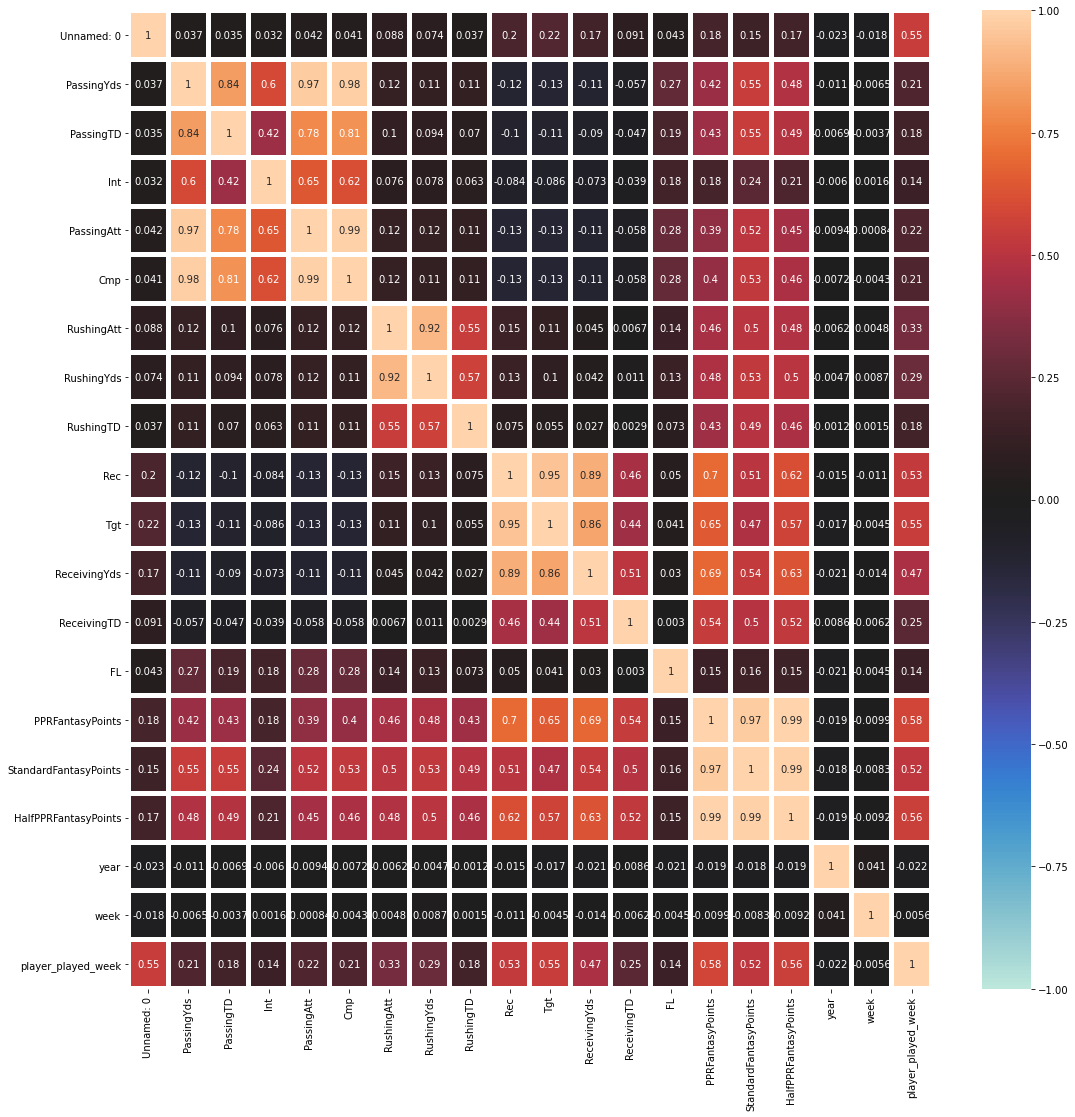

In [7]:
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, annot=True, linewidths=4);

# Making 1 model for all positions: PPRFantasy

### Model Creation

In [8]:
##Training: 2019 and 2020
##Testing: 2021

df_train = df[(df['year'] == 2019)  | (df['year'] == 2020)]
df_test_all = df[df['year'] == 2021]

##Set index to player
df_train = df_train.set_index('Player')
df_test_all = df_test_all.set_index('Player')
##Need to encode: Pos
df_test_all['Pos2'] = df_test_all['Pos']
df_train = pd.get_dummies(df_train, columns = ['Pos'], drop_first = False)
df_test_all = pd.get_dummies(df_test_all, columns = ['Pos'], drop_first = False)

##Get columns going to be used 
df_trainX = df_train[['PassingYds', 'PassingTD', 'Int',
       'PassingAtt', 'Cmp', 'RushingAtt', 'RushingYds', 'RushingTD', 'Rec',
       'Tgt', 'ReceivingYds', 'ReceivingTD', 'FL', 'year', 'week', 'player_played_week',
          'Pos_QB', 'Pos_RB', 'Pos_TE', 'Pos_WR']]
df_trainY = df_train[["PPRFantasyPoints"]]

df_testX = df_test_all[['PassingYds', 'PassingTD', 'Int',
       'PassingAtt', 'Cmp', 'RushingAtt', 'RushingYds', 'RushingTD', 'Rec',
       'Tgt', 'ReceivingYds', 'ReceivingTD', 'FL', 'year', 'week', 'player_played_week',
          'Pos_QB', 'Pos_RB', 'Pos_TE', 'Pos_WR']]
df_testY = df_test_all[["PPRFantasyPoints"]]

##Normalize columns 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_trainX_scaled = scaler.fit_transform(df_trainX)
#df_trainY_scaled = scaler.fit_transform(df_trainY)

df_testX_scaled = scaler.fit_transform(df_testX)
#df_testY_scaled = scaler.fit_transform(df_testY)

##Random Forest Model
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state = 14)
regressor.fit(df_trainX_scaled, df_trainY)

predictions_rf = regressor.predict(df_testX_scaled)

##XGBoost Model
import xgboost as xg

xgb = xg.XGBRegressor(random_state = 14)
xgb.fit(df_trainX_scaled, df_trainY)

predictions_xgb = xgb.predict(df_testX_scaled)


C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


### Feature Importance

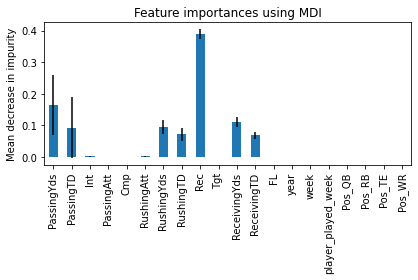

In [9]:
##Source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

importances = regressor.feature_importances_
forest_importances = pd.Series(importances, index= df_trainX.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

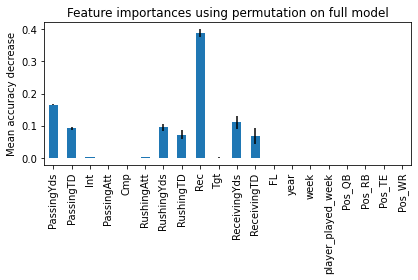

In [10]:
##Source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regressor, df_testX, df_testY, n_repeats=3, random_state=42
)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

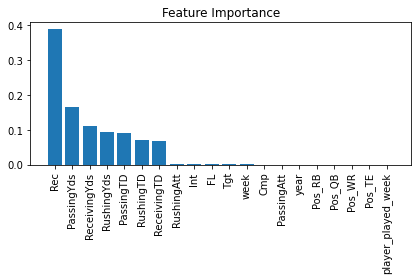

In [11]:
##Source: https://vitalflux.com/feature-importance-random-forest-classifier-python/
import matplotlib.pyplot as plt

importances = regressor.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
 
plt.title('Feature Importance')
plt.bar(range(df_trainX.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(df_trainX.shape[1]), df_trainX.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

### Accuracy/Performance

In [12]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(df_testY, predictions_rf))
print('Mean Squared Error:', metrics.mean_squared_error(df_testY, predictions_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_testY, predictions_rf)))

Mean Absolute Error: 0.5560928402086291
Mean Squared Error: 0.9116919009388322
Root Mean Squared Error: 0.9548255866590674


In [13]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(df_testY, predictions_xgb))
print('Mean Squared Error:', metrics.mean_squared_error(df_testY, predictions_xgb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_testY, predictions_xgb)))

Mean Absolute Error: 0.8785088468213508
Mean Squared Error: 2.734156418752329
Root Mean Squared Error: 1.6535284753376123


In [14]:
pred_l_rf = list(predictions_rf)
df_test_all['predictions_rf'] = pred_l_rf

pred_l_xgb = list(predictions_xgb)
df_test_all['predictions_xgb'] = pred_l_xgb

df_test_all['error_%_rf'] = abs(((df_test_all['predictions_rf'] - df_test_all['PPRFantasyPoints']) / df_test_all['PPRFantasyPoints']) * 100).round(1)
df_test_all['error_%_xgb'] = abs(((df_test_all['predictions_xgb'] - df_test_all['PPRFantasyPoints']) / df_test_all['PPRFantasyPoints']) * 100).round(1)
df_test_all.head(3)

,Unnamed: 0,Tm,PassingYds,PassingTD,Int,PassingAtt,Cmp,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,FL,PPRFantasyPoints,StandardFantasyPoints,HalfPPRFantasyPoints,year,week,player_played_week,Pos2,Pos_QB,Pos_RB,Pos_TE,Pos_WR,predictions_rf,predictions_xgb,error_%_rf,error_%_xgb
Player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Amari Cooper,0,DAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,17.0,139.0,2.0,0.0,38.90,25.90,32.40,2021,1,1,WR,0,0,0,1,42.9620,48.056931,10.4,23.5
Tyreek Hill,1,KAN,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,11.0,15.0,197.0,1.0,0.0,37.10,26.10,31.60,2021,1,1,WR,0,0,0,1,37.7430,38.338734,1.7,3.3
Patrick Mahomes,2,KAN,337.0,3.0,0.0,36.0,27.0,5.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,33.28,33.28,33.28,2021,1,1,QB,1,0,0,0,32.3558,35.815083,2.8,7.6


In [15]:
error = df_test_all[df_test_all['error_%_rf'] != np.inf]
print('Median error % RF ',error['error_%_rf'].median())
print('Avg error % RF ',error['error_%_rf'].mean())
print("-------------------------------------------------------------------")
print('Median error % XGB ',error['error_%_xgb'].median())
print('Avg error % XGB ',error['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - np.mean(error['error_%_rf']))
print('Average Accuracy XGB', 100 - np.mean(error['error_%_xgb']))

Median error % RF  6.5
Avg error % RF  16.941998358637655
-------------------------------------------------------------------
Median error % XGB  7.6
Avg error % XGB  20.392798522773816
-------------------------------------------------------------------
Average Accuracy RF 83.05800164136235
Average Accuracy XGB 79.60720147722618


In [16]:
error = df_test_all[df_test_all['error_%_rf'] != np.inf]
print('Median error % RF ', error.groupby('Pos2')['error_%_rf'].median())
print('Median error % XGB ', error.groupby('Pos2')['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - error.groupby('Pos2')['error_%_rf'].mean())
print('Average Accuracy RF', 100 -  error.groupby('Pos2')['error_%_xgb'].mean())

Median error % RF  Pos2
QB     5.30
RB    14.85
TE     4.60
WR     3.70
Name: error_%_rf, dtype: float64
Median error % XGB  Pos2
QB    25.105120
RB    42.072775
TE     8.625606
WR     9.994732
Name: error_%_xgb, dtype: float64
-------------------------------------------------------------------
Average Accuracy RF Pos2
QB    79.267040
RB    67.465686
TE    90.427397
WR    91.189311
Name: error_%_rf, dtype: float64
Average Accuracy RF Pos2
QB    74.894880
RB    57.927225
TE    91.374394
WR    90.005268
Name: error_%_xgb, dtype: float64


## Why is running back accuracy so low?

# Creating Model with just top 5 important features

In [17]:
##Training: 2019 and 2020
##Testing: 2021

df_train = df[(df['year'] == 2019)  | (df['year'] == 2020)]
df_test = df[df['year'] == 2021]

##Set index to player
df_train = df_train.set_index('Player')
df_test = df_test.set_index('Player')
##Need to encode: Pos
df_test['Pos2'] = df_test['Pos']
df_train = pd.get_dummies(df_train, columns = ['Pos'], drop_first = False)
df_test = pd.get_dummies(df_test, columns = ['Pos'], drop_first = False)

##Get columns going to be used 
df_trainX = df_train[['PassingYds', 'Rec', 'ReceivingYds', 'RushingYds', 'PassingTD']]
df_trainY = df_train[["PPRFantasyPoints"]]

df_testX = df_test[['PassingYds', 'Rec', 'ReceivingYds', 'RushingYds', 'PassingTD']]
df_testY = df_test[["PPRFantasyPoints"]]

##Normalize columns 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_trainX_scaled = scaler.fit_transform(df_trainX)
#df_trainY_scaled = scaler.fit_transform(df_trainY)

df_testX_scaled = scaler.fit_transform(df_testX)
#df_testY_scaled = scaler.fit_transform(df_testY)

##Random Forest Model
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state = 14)
regressor.fit(df_trainX_scaled, df_trainY)

predictions_rf = regressor.predict(df_testX_scaled)

##XGBoost Model
import xgboost as xg

xgb = xg.XGBRegressor(random_state = 14)
xgb.fit(df_trainX_scaled, df_trainY)

predictions_xgb = xgb.predict(df_testX_scaled)


C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [18]:
pred_l_rf = list(predictions_rf)
df_test['predictions_rf'] = pred_l_rf

pred_l_xgb = list(predictions_xgb)
df_test['predictions_xgb'] = pred_l_xgb

df_test['error_%_rf'] = abs(((df_test['predictions_rf'] - df_test['PPRFantasyPoints']) / df_test['PPRFantasyPoints']) * 100).round(1)
df_test['error_%_xgb'] = abs(((df_test['predictions_xgb'] - df_test['PPRFantasyPoints']) / df_test['PPRFantasyPoints']) * 100).round(1)

In [19]:
error = df_test[df_test['error_%_rf'] != np.inf]
print('Median error % RF ',error['error_%_rf'].median())
print('Avg error % RF ',error['error_%_rf'].mean())
print("-------------------------------------------------------------------")
print('Median error % XGB ',error['error_%_xgb'].median())
print('Avg error % XGB ',error['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - np.mean(error['error_%_rf']))
print('Average Accuracy XGB', 100 - np.mean(error['error_%_xgb']))

Median error % RF  26.9
Avg error % RF  49.823820270824584
-------------------------------------------------------------------
Median error % XGB  30.7
Avg error % XGB  48.03563807960648
-------------------------------------------------------------------
Average Accuracy RF 50.176179729175416
Average Accuracy XGB 51.96436192039352


# Model for just one Position (RB)

In [20]:
##Training: 2019 and 2020
##Testing: 2021

df_qb = df[df['Pos'] =="RB"]

df_train = df_qb[(df_qb['year'] == 2019)  | (df['year'] == 2020)]
df_test = df_qb[df_qb['year'] == 2021]

##Set index to player
df_train = df_train.set_index('Player')
df_test = df_test.set_index('Player')

##Get columns going to be used 
df_trainX = df_train[['RushingAtt', 'RushingYds', 'RushingTD', 'Rec',
       'Tgt', 'ReceivingYds', 'ReceivingTD', 'FL', 'year', 'week', 'player_played_week']]
df_trainY = df_train[["PPRFantasyPoints"]]

df_testX = df_test[['RushingAtt', 'RushingYds', 'RushingTD', 'Rec',
       'Tgt', 'ReceivingYds', 'ReceivingTD', 'FL', 'year', 'week', 'player_played_week']]
df_testY = df_test[["PPRFantasyPoints"]]

##Normalize columns 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_trainX_scaled = scaler.fit_transform(df_trainX)
#df_trainY_scaled = scaler.fit_transform(df_trainY)

df_testX_scaled = scaler.fit_transform(df_testX)
#df_testY_scaled = scaler.fit_transform(df_testY)

##Random Forest Model
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state = 14)
regressor.fit(df_trainX_scaled, df_trainY)

predictions_rf = regressor.predict(df_testX_scaled)

##XGBoost Model
import xgboost as xg

xgb = xg.XGBRegressor(random_state = 14)
xgb.fit(df_trainX_scaled, df_trainY)

predictions_xgb = xgb.predict(df_testX_scaled)


C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [21]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(df_testY, predictions_rf))
print('Mean Squared Error:', metrics.mean_squared_error(df_testY, predictions_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_testY, predictions_rf)))

Mean Absolute Error: 0.6229713027522935
Mean Squared Error: 1.6927780276844027
Root Mean Squared Error: 1.3010680334572833


In [22]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(df_testY, predictions_xgb))
print('Mean Squared Error:', metrics.mean_squared_error(df_testY, predictions_xgb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_testY, predictions_xgb)))

Mean Absolute Error: 1.3275865395837025
Mean Squared Error: 7.209915545527533
Root Mean Squared Error: 2.685128590128885


In [23]:
pred_l_rf = list(predictions_rf)
df_test['predictions_rf'] = pred_l_rf

pred_l_xgb = list(predictions_xgb)
df_test['predictions_xgb'] = pred_l_xgb

df_test['error_%_rf'] = abs(((df_test['predictions_rf'] - df_test['PPRFantasyPoints']) / df_test['PPRFantasyPoints']) * 100).round(1)
df_test['error_%_xgb'] = abs(((df_test['predictions_xgb'] - df_test['PPRFantasyPoints']) / df_test['PPRFantasyPoints']) * 100).round(1)

# df_test['rf_diff'] = abs((df_test['predictions_rf'] - df_test['PPRFantasyPoints']))
# df_test['xgb_diff'] = abs((df_test['predictions_xgb'] - df_test['PPRFantasyPoints']))


df_test.head(3)

,Unnamed: 0,Pos,Tm,PassingYds,PassingTD,Int,PassingAtt,Cmp,RushingAtt,RushingYds,RushingTD,Rec,Tgt,ReceivingYds,ReceivingTD,FL,PPRFantasyPoints,StandardFantasyPoints,HalfPPRFantasyPoints,year,week,player_played_week,predictions_rf,predictions_xgb,error_%_rf,error_%_xgb
Player,,,,,,,,,,,,,,,,,,,,,,,,,,
Joe Mixon,15,RB,CIN,0.0,0.0,0.0,0.0,0.0,29.0,127.0,1.0,4.0,4.0,23.0,0.0,0.0,25.0,21.0,23.0,2021,1,1,26.1900,35.263451,4.8,41.1
Christian McCaffrey,16,RB,CAR,0.0,0.0,0.0,0.0,0.0,21.0,98.0,0.0,9.0,9.0,89.0,0.0,0.0,27.7,18.7,23.2,2021,1,1,29.7200,32.576473,7.3,17.6
Jamaal Williams,30,RB,DET,0.0,0.0,0.0,0.0,0.0,9.0,54.0,1.0,8.0,9.0,56.0,0.0,0.0,25.0,17.0,21.0,2021,1,1,27.2898,34.263550,9.2,37.1


In [24]:
error = df_test[df_test['error_%_rf'] != np.inf]
print('Median error % RF ',error['error_%_rf'].median())
print('Avg error % RF ',error['error_%_rf'].mean())
print("-------------------------------------------------------------------")
print('Median error % XGB ',error['error_%_xgb'].median())
print('Avg error % XGB ',error['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - np.mean(error['error_%_rf']))
print('Average Accuracy XGB', 100 - np.mean(error['error_%_xgb']))

Median error % RF  9.7
Avg error % RF  22.31334841628959
-------------------------------------------------------------------
Median error % XGB  14.05
Avg error % XGB  29.568552036199122
-------------------------------------------------------------------
Average Accuracy RF 77.68665158371041
Average Accuracy XGB 70.43144796380088


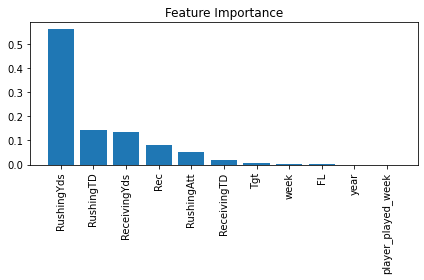

In [25]:
##Source: https://vitalflux.com/feature-importance-random-forest-classifier-python/


importances = regressor.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
 
plt.title('Feature Importance')
plt.bar(range(df_trainX.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(df_trainX.shape[1]), df_trainX.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Bayesian Statistics Model

In [26]:
import arviz as az
import pymc as pm
import warnings
from sklearn.preprocessing import MinMaxScaler

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8296
np.random.seed(RANDOM_SEED)

In [27]:
player_df = df[df['Player'] == 'Josh Jacobs']
player_df = player_df.sort_values(by=['year', 'week'])
len(player_df)

52

In [28]:
player_train = player_df[(player_df['year'] == 2019)  | (df['year'] == 2020)]
player_test = player_df[player_df['year'] == 2021]

C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [29]:
player_to_scale_train = player_train[['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds']]
player_to_scale_test = player_test[['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds']]

scaler = MinMaxScaler()
scaled_train_player = scaler.fit_transform(player_to_scale_train)
scaled_train_player_df = pd.DataFrame(scaled_train_player, columns =['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds'])

scaled_test_player = scaler.fit_transform(player_to_scale_test)
scaled_test_player_df = pd.DataFrame(scaled_test_player, columns =['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds'])

In [30]:
scaled_train_player_df.head()

,RushingAtt,RushingYds,RushingTD,Rec,ReceivingYds
0,0.741935,0.664062,0.666667,0.25,0.608696
1,0.387097,0.773438,0.000000,0.00,0.000000
2,0.322581,0.343750,0.000000,0.00,0.000000
3,0.548387,0.617188,0.000000,0.50,0.630435
4,0.838710,0.960938,0.666667,0.75,0.434783


In [31]:
scaled_train_player_df['RushingAtt'].values

array([0.74193548, 0.38709677, 0.32258065, 0.5483871 , 0.83870968,
       0.        , 0.67741935, 0.48387097, 0.90322581, 0.51612903,
       0.74193548, 0.32258065, 0.5483871 , 0.        , 0.77419355,
       0.        , 0.        , 0.80645161, 0.87096774, 0.51612903,
       0.48387097, 0.74193548, 0.        , 0.32258065, 1.        ,
       0.4516129 , 0.67741935, 0.5483871 , 0.22580645, 0.        ,
       0.41935484, 0.83870968, 0.41935484, 0.48387097])

## Creating Bayesian Linear Regression Model

In [32]:
with pm.Model() as player_model:
    
    #Data
    rushing_att = pm.MutableData("RushingAtt", scaled_train_player_df['RushingAtt'].values)
    rushing_yd = pm.MutableData("RushingYds", scaled_train_player_df['RushingYds'].values)
    rushing_td = pm.MutableData("RushingTD", scaled_train_player_df['RushingTD'].values)
    rec = pm.MutableData("Rec", scaled_train_player_df['Rec'].values)
    receiving_yds = pm.MutableData("ReceivingYds", scaled_train_player_df['ReceivingYds'].values)
    
    #prior
    intercept = pm.HalfCauchy('intercept', .001)
    
    #slope
    slope = pm.Gamma("slope", alpha = 50, beta =1)
    
    #linear regression
    mu = (
        intercept + (slope * rushing_att) + (slope * rushing_yd) + (slope * rushing_td) 
        + (slope * receiving_yds) + (slope * rec)
    )
    
    #noise
    eps = pm.HalfNormal("eps", 1.0)
    
    pm.Normal(
    "PPRFantasyPoints",
    mu=mu,
    sigma=eps,
    observed= player_train['PPRFantasyPoints'].values
    )
    
    

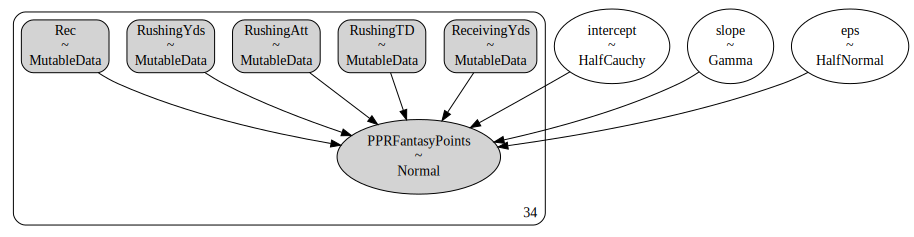

In [33]:
pm.model_to_graphviz(player_model)

In [34]:
with player_model:
    idata = pm.sample(random_seed=RANDOM_SEED)
    idata.extend(pm.sample_prior_predictive(random_seed=RANDOM_SEED))
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

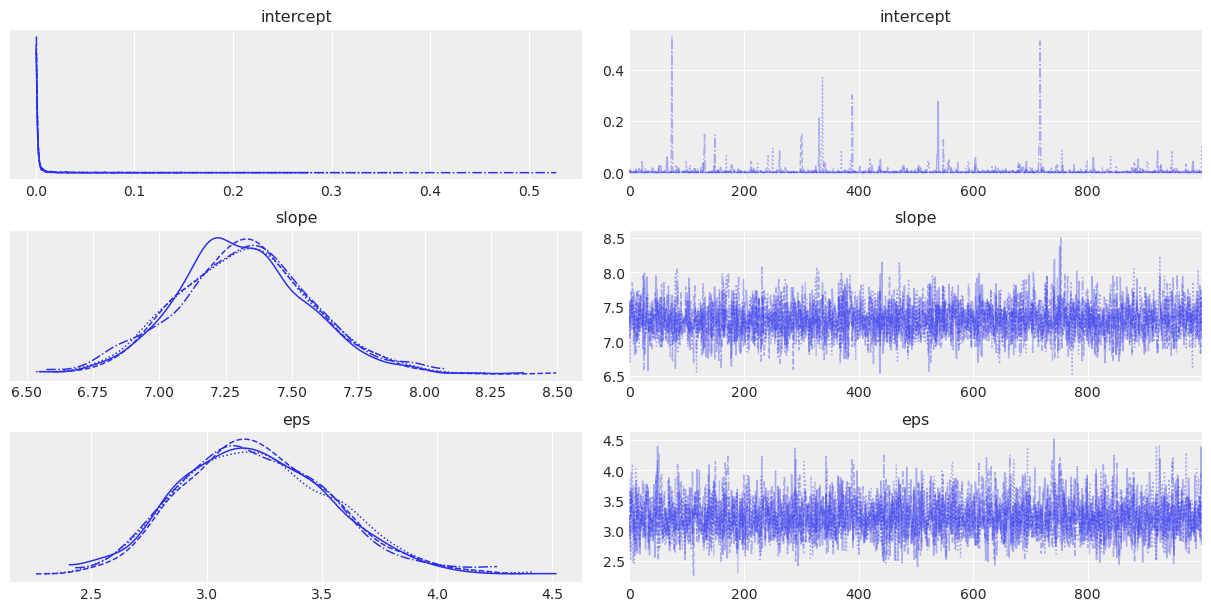

In [35]:
az.plot_trace(idata)

Text(0.5, 0, 'obs')

C:\Users\matt\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


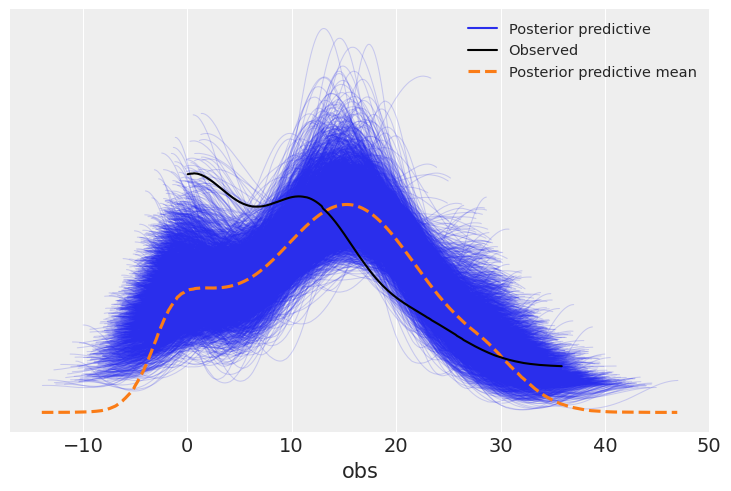

In [36]:
ax = az.plot_ppc(idata)
ax.set_xlabel("obs")

Text(0.5, 0, 'obs')

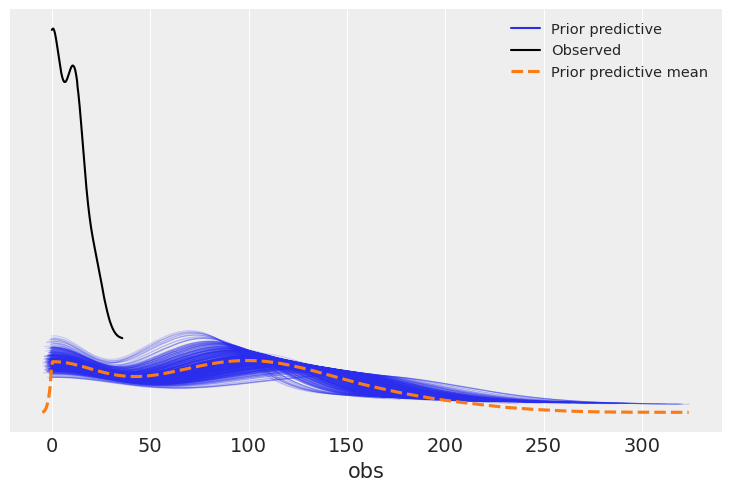

In [37]:
ax = az.plot_ppc(idata, group="prior")
ax.set_xlabel("obs")

## Create Predictions

In [38]:
with player_model:
    pm.set_data(
        {
            "RushingAtt": scaled_test_player_df['RushingAtt'].values,
            "RushingYds": scaled_test_player_df['RushingYds'].values,
            "RushingTD": scaled_test_player_df['RushingTD'].values,
            "Rec" : scaled_test_player_df['Rec'].values,
            "ReceivingYds": scaled_test_player_df['ReceivingYds'].values
        }
    )

with player_model:
    idata = pm.sample_posterior_predictive(
        idata,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )
    

In [39]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

array([[<AxesSubplot:title={'center':'PPRFantasyPoints\n0'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n1'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n2'}>],
       [<AxesSubplot:title={'center':'PPRFantasyPoints\n3'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n4'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n5'}>],
       [<AxesSubplot:title={'center':'PPRFantasyPoints\n6'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n7'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n8'}>],
       [<AxesSubplot:title={'center':'PPRFantasyPoints\n9'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n10'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n11'}>],
       [<AxesSubplot:title={'center':'PPRFantasyPoints\n12'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n13'}>,
        <AxesSubplot:title={'center':'PPRFantasyPoints\n14'}>],
       [<AxesSubplot:title={'center':'PPRFantasyPoints\n15'}

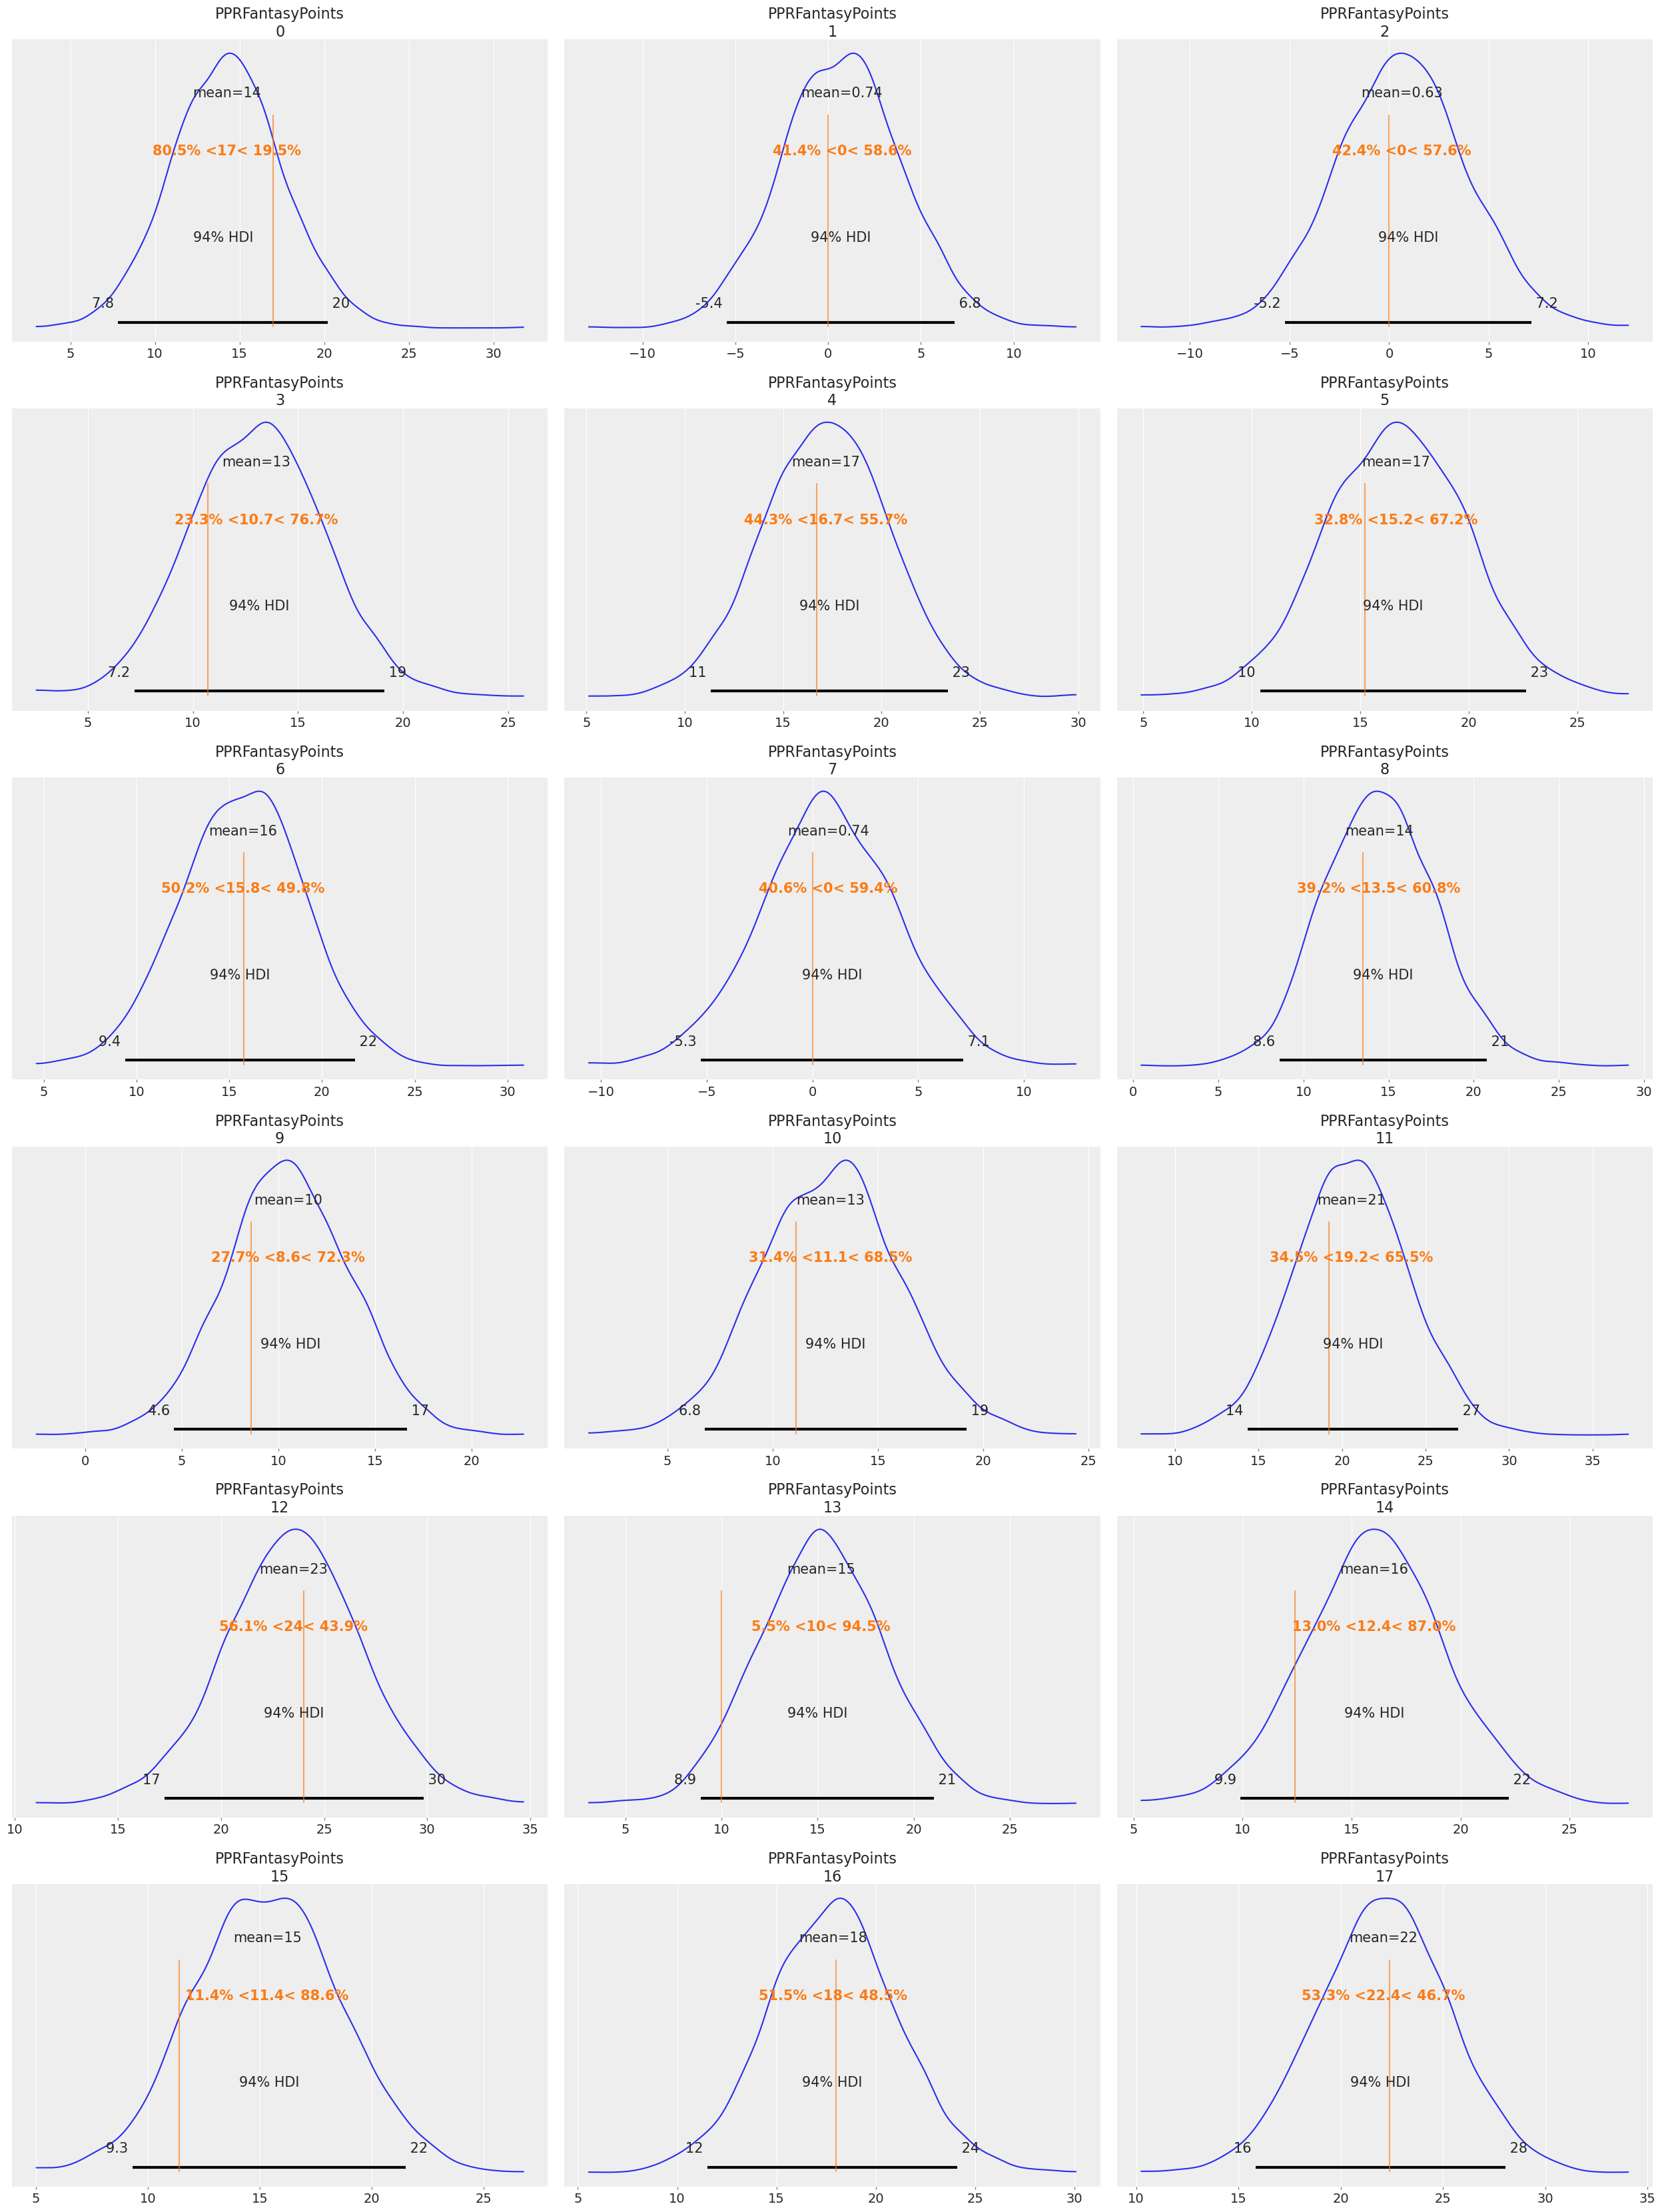

In [40]:
az.plot_posterior(
    idata.predictions,
    ref_val = player_test['PPRFantasyPoints'].tolist()
)

In [41]:
predictions = idata.predictions
predictions

<xarray.Dataset>
Dimensions:                 (chain: 4, draw: 1000, PPRFantasyPoints_dim_0: 18)
Coordinates:
  * chain                   (chain) int32 0 1 2 3
  * draw                    (draw) int32 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * PPRFantasyPoints_dim_0  (PPRFantasyPoints_dim_0) int32 0 1 2 3 ... 15 16 17
Data variables:
    PPRFantasyPoints        (chain, draw, PPRFantasyPoints_dim_0) float64 14....
Attributes:
    created_at:                 2022-12-17T23:37:25.259343
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4

In [42]:
one_pred = predictions.mean(dim=("chain", "draw")).round(2)
final_pred = one_pred['PPRFantasyPoints'].values

test = scaler.inverse_transform(scaled_test_player_df)
test_df =  pd.DataFrame(test, columns =['RushingAtt', 'RushingYds', 'RushingTD', 'Rec', 'ReceivingYds'])

test_df['PPRFantasyPoints'] = player_test['PPRFantasyPoints'].values
test_df['prediction'] = final_pred

test_df['error_%'] = abs(((test_df['prediction'] - test_df['PPRFantasyPoints']) / test_df['PPRFantasyPoints']) * 100).round(1)

error = test_df[test_df['error_%'] != np.inf]
print('Median error % ',error['error_%'].median())
print('Avg error % ',error['error_%'].mean())
print('Average Accuracy', 100 - np.mean(error['error_%']))

Median error %  9.6
Avg error %  14.753333333333334
Average Accuracy 85.24666666666667


## Testing Bayesian Function with other players running backs

In [49]:

dh = bayesian_LR("Derrick Henry")

error = dh[dh['error_%'] != np.inf]
print('Median error Bayes % ',error['error_%'].median())
print('Avg error Bayes % ',error['error_%'].mean())
print('Average Accuracy Bayes', 100 - np.mean(error['error_%']))

print("-------------------------------------------------------------------")
player = ['Derrick Henry']
dh_all = df_test_all[df_test_all.index.isin(player)]

error = dh_all[dh_all['error_%_rf'] != np.inf]
print('Median error % RF ',error['error_%_rf'].median())
print('Avg error % RF ',error['error_%_rf'].mean())
print("-------------------------------------------------------------------")
print('Median error % XGB ',error['error_%_xgb'].median())
print('Avg error % XGB ',error['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - np.mean(error['error_%_rf']))
print('Average Accuracy XGB', 100 - np.mean(error['error_%_xgb']))

C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


Median error Bayes %  22.3
Avg error Bayes %  35.28750000000001
Average Accuracy Bayes 64.71249999999999
-------------------------------------------------------------------
Median error % RF  9.85
Avg error % RF  10.1
-------------------------------------------------------------------
Median error % XGB  20.4
Avg error % XGB  20.6375
-------------------------------------------------------------------
Average Accuracy RF 89.9
Average Accuracy XGB 79.3625


In [51]:

dh = bayesian_LR("Joe Mixon")

error = dh[dh['error_%'] != np.inf]
print('Median error Bayes % ',error['error_%'].median())
print('Avg error Bayes % ',error['error_%'].mean())
print('Average Accuracy Bayes', 100 - np.mean(error['error_%']))

print("-------------------------------------------------------------------")
player = ['Joe Mixon']
dh_all = df_test_all[df_test_all.index.isin(player)]

error = dh_all[dh_all['error_%_rf'] != np.inf]
print('Median error % RF ',error['error_%_rf'].median())
print('Avg error % RF ',error['error_%_rf'].mean())
print("-------------------------------------------------------------------")
print('Median error % XGB ',error['error_%_xgb'].median())
print('Avg error % XGB ',error['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - np.mean(error['error_%_rf']))
print('Average Accuracy XGB', 100 - np.mean(error['error_%_xgb']))

C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.


Median error Bayes %  14.45
Avg error Bayes %  14.599999999999998
Average Accuracy Bayes 85.4
-------------------------------------------------------------------
Median error % RF  14.649999999999999
Avg error % RF  16.55
-------------------------------------------------------------------
Median error % XGB  22.25
Avg error % XGB  32.337500000000006
-------------------------------------------------------------------
Average Accuracy RF 83.45
Average Accuracy XGB 67.6625


In [52]:

dh = bayesian_LR("Nick Chubb")

error = dh[dh['error_%'] != np.inf]
print('Median error Bayes % ',error['error_%'].median())
print('Avg error Bayes % ',error['error_%'].mean())
print('Average Accuracy Bayes', 100 - np.mean(error['error_%']))

print("-------------------------------------------------------------------")
player = ['Nick Chubb']
dh_all = df_test_all[df_test_all.index.isin(player)]

error = dh_all[dh_all['error_%_rf'] != np.inf]
print('Median error % RF ',error['error_%_rf'].median())
print('Avg error % RF ',error['error_%_rf'].mean())
print("-------------------------------------------------------------------")
print('Median error % XGB ',error['error_%_xgb'].median())
print('Avg error % XGB ',error['error_%_xgb'].mean())
print("-------------------------------------------------------------------")
print('Average Accuracy RF', 100 - np.mean(error['error_%_rf']))
print('Average Accuracy XGB', 100 - np.mean(error['error_%_xgb']))

C:\Users\matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


Median error Bayes %  27.35
Avg error Bayes %  37.17142857142857
Average Accuracy Bayes 62.82857142857143
-------------------------------------------------------------------
Median error % RF  16.65
Avg error % RF  18.357142857142858
-------------------------------------------------------------------
Median error % XGB  25.15
Avg error % XGB  27.307142857142857
-------------------------------------------------------------------
Average Accuracy RF 81.64285714285714
Average Accuracy XGB 72.69285714285715
